In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install --upgrade mxnet==1.6.0
!pip install gluonts

In [48]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
import matplotlib.pyplot as plt
import seaborn as sns 

In [67]:
dataset = pd.read_csv('/content/drive/MyDrive/care4better/time_series/kiethtracking.csv',parse_dates=True)

In [68]:
dataset

,Date,Daily Total Streams
0,2021-05-19,0
1,2021-05-20,0
2,2021-05-21,0
3,2021-05-22,0
4,2021-05-23,0
...,...,...
168,2021-11-03,1838
169,2021-11-04,1613
170,2021-11-05,6479
171,2021-11-06,4722


In [69]:
dataset['Date'] = pd.to_datetime(dataset['Date'],format='%Y-%m')
dataset.head(169)

,Date,Daily Total Streams
0,2021-05-19,0
1,2021-05-20,0
2,2021-05-21,0
3,2021-05-22,0
4,2021-05-23,0
...,...,...
164,2021-10-30,2121
165,2021-10-31,2472
166,2021-11-01,1860
167,2021-11-02,1408


In [70]:
def find_missing_value(data):
  missed_val = pd.DataFrame({'column_name':[],'missing_value':[],'missing_percentage':[]})
  for col in data.columns:
    sum_missing_value = data[col].isnull().sum()
    percent_miss_value = round(sum_missing_value/data.shape[0]*100,2)
    missed_val = missed_val.append(dict(zip(missed_val.columns,[col,sum_missing_value,percent_miss_value])),ignore_index = True)
  return missed_val  

In [71]:
missing_value = find_missing_value(dataset)
display(missing_value[missing_value['missing_percentage']>0.0])
print("\n")
print(f"Number of columns with missing values:{str(missing_value[missing_value['missing_percentage']>0.0].shape[0])}")

,column_name,missing_value,missing_percentage




Number of columns with missing values:0


In [72]:
dataset.describe()


,Daily Total Streams
count,173.000000
mean,1273.988439
std,1391.369453
min,0.000000
25%,356.000000
50%,1014.000000
75%,1682.000000
max,9724.000000


In [73]:
dataset.index = dataset['Date']
del dataset['Date']
print(dataset.head())

            Daily Total Streams
Date                           
2021-05-19                    0
2021-05-20                    0
2021-05-21                    0
2021-05-22                    0
2021-05-23                    0


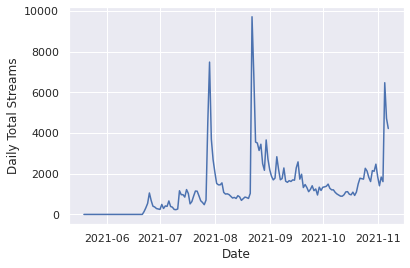

In [74]:
sns.lineplot(x=dataset.index,y=dataset['Daily Total Streams'])
plt.ylabel('Daily Total Streams')
plt.show()

In [75]:
rolling_mean = dataset.rolling(10).mean()
rolling_std = dataset.rolling(10).std()

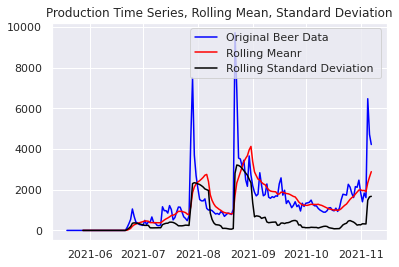

In [76]:
plt.plot(dataset, color="blue",label="Original Beer Data")
plt.plot(rolling_mean, color="red", label="Rolling Meanr")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation ")
plt.title("Production Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

In [77]:
data = dataset.iloc[:,0].values

In [78]:
type(data)
data

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  141,  325,  541, 1055,  685,  405,  365,  289,  268,  246,
        491,  292,  417,  396,  662,  389,  356,  245,  233,  268, 1164,
        970,  972,  852, 1222, 1029,  519,  631,  902, 1150, 1142,  915,
        672,  589,  478,  704, 4515, 7493, 3706, 2690, 2075, 1524, 1456,
       1453, 1551, 1084, 1001, 1014,  975,  892,  807,  836,  784,  921,
        861,  691,  773,  854,  828,  785, 1036, 9724, 6879, 3559, 3513,
       3146, 3453, 2496, 2170, 3663, 2722, 2197, 1877, 1699, 1788, 2838,
       2215, 1703, 1764, 2285, 1635, 1579, 1660, 1620, 1700, 1682, 2292,
       2585, 1734, 1976, 1322, 1470, 1322, 1118, 1231, 1410, 1169, 1252,
        955, 1340, 1179, 1336, 1355, 1385, 1491, 1282, 1209, 1208, 1084,
       1004,  954,  899,  896,  968, 1109, 1119,  9

In [79]:
adft = adfuller(data,autolag="AIC")

In [80]:
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0   -4.915103              Test Statistics
1    0.000033                      p-value
2    0.000000             No. of lags used
3  172.000000  Number of observations used
4   -3.468952          critical value (1%)
5   -2.878495          critical value (5%)
6   -2.575809         critical value (10%)


In [81]:
autocorrelation_lag1 = dataset['Daily Total Streams'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)
autocorrelation_lag2 = dataset['Daily Total Streams'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag2)
autocorrelation_lag3 = dataset['Daily Total Streams'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag3)
autocorrelation_lag4 = dataset['Daily Total Streams'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag4)

One Month Lag:  0.7325821279353281
Three Month Lag:  0.4253740820401519
Six Month Lag:  0.3378768876736717
Nine Month Lag:  0.2754898917186944


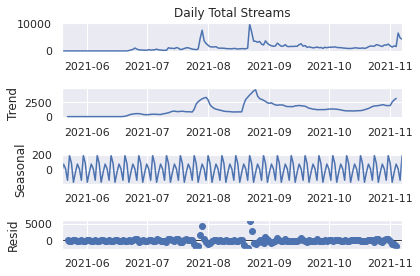

In [82]:
decompose = seasonal_decompose(dataset['Daily Total Streams'],model='additive')
decompose.plot()
plt.show()

In [83]:
dataset.rename(columns={'Daily Total Streams':'mbp'},inplace=True)
dataset.head(150)
type(dataset.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [163]:
train_time = '2021-09-15'

In [162]:
dataset.head(120)

,mbp
Date,
2021-05-19,0
2021-05-20,0
2021-05-21,0
2021-05-22,0
2021-05-23,0
...,...
2021-09-11,1579
2021-09-12,1660
2021-09-13,1620


In [368]:
prediction_length = 50
freq = '1D'

In [106]:
freq = '1D'
start_train = pd.Timestamp("1956-01-01 00:00:00", freq=freq) ## start index
start_test = pd.Timestamp("1987-09-01 00:00:00", freq=freq) ## start_index for test_set verify by df_all.columns[40000:].shape == df_test.shape


In [369]:
estimator = DeepAREstimator(freq=freq, 
                            context_length=100, ## context length is number of time steps will look back here it is 7 years
                            prediction_length=prediction_length,
                            
                           
                            num_layers=2,
                            num_cells=32,
                            cell_type='lstm',
                            dropout_rate = 0.25,
                            trainer=Trainer(epochs=20 , learning_rate=1e-3  ,batch_size = 512, patience = 5 ))

In [370]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([{"start":dataset.index[0],"target":dataset.mbp[:train_time]}], freq=freq)



In [318]:
dataset.index[119]

Timestamp('2021-09-15 00:00:00')

In [371]:
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:08<00:00,  5.66it/s, epoch=20/20, avg_epoch_loss=4.87]


In [357]:
test_ds = ListDataset([{"start":dataset.index[119],"target":dataset.mbp['2021-11-03':'2021-11-07']}
                       ], freq=freq)

In [244]:
import datetime
start = datetime.datetime(2021, 11, 9)
end = datetime.datetime(2022, 11, 9)


In [358]:
test = list(test_ds)
test

[{'source': SourceContext(source='list_data', row=0),
  'start': Timestamp('2021-09-15 00:00:00', freq='D'),
  'target': array([1838., 1613., 6479., 4722., 4226.], dtype=float32)}]

In [366]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, ts_it =  make_evaluation_predictions(
    dataset=test_ds,  
    predictor=predictor,  
    num_samples=1, 
)



In [367]:
forecast = list(forecast_it)
tss = list(ts_it)
print(forecast)

[gluonts.model.forecast.SampleForecast(freq="1D", info=None, item_id=None, samples=numpy.array([[1.1816353451266082e-11, -3.2628927337796654e-11, -6.761690513057417e-11, -1.0337778376390272e-11, 1.0748145429229083e-11]], numpy.dtype("float32")), start_date=pandas.Timestamp("2021-09-15 00:00:00", freq="D"))]


In [341]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 10
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

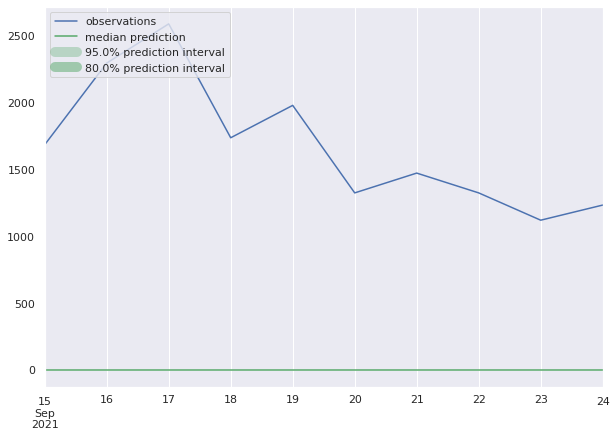

In [342]:
plot_prob_forecasts(tss[0],forecast[0])

In [202]:
ts = list(test_ds)
ts

[{'source': SourceContext(source='list_data', row=0),
  'start': Timestamp('2021-05-19 00:00:00', freq='D'),
  'target': array([1682., 2292., 2585., 1734., 1976., 1322., 1470., 1322., 1118.,
         1231., 1410., 1169., 1252.,  955., 1340., 1179., 1336., 1355.,
         1385., 1491., 1282., 1209., 1208., 1084., 1004.,  954.,  899.,
          896.,  968., 1109., 1119.,  992.,  964., 1095.,  935., 1103.,
         1501., 1780., 1757., 1735., 2269., 2132., 1821., 1617., 2154.,
         2121., 2472., 1860., 1408., 1838., 1613., 6479., 4722., 4226.],
        dtype=float32)}]

Arima


In [361]:
df = dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


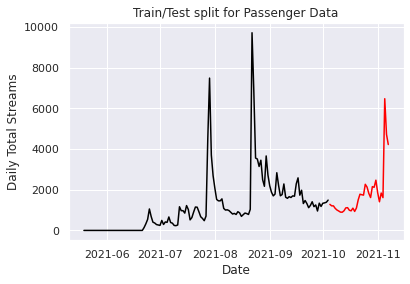

In [362]:
df['Date'] = df.index
train = df[df['Date'] < pd.to_datetime("2021-10-05", format='%Y-%m-%d')]
train['train'] = train['mbp']
del train['Date']
del train['mbp']
test = df[df['Date'] >= pd.to_datetime("2021-10-05", format='%Y-%m-%d')]
del test['Date']
test['test'] = test['mbp']
del test['mbp']
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Daily Total Streams")
plt.xlabel('Date')
sns.set()
plt.show()

In [363]:
!pip install pmdarima


In [364]:
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2310.243, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2311.610, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2310.424, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2308.262, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.770 seconds


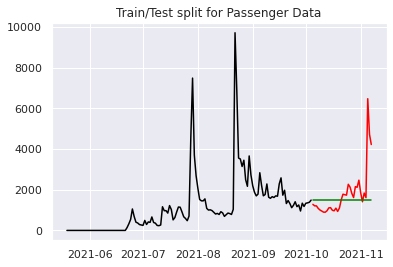

In [365]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(forecast, color = "green")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("")
plt.xlabel('')
sns.set()
plt.show()